In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import math
from scipy.stats.mstats import gmean
from scipy.stats import gamma, poisson, linregress, beta, norm
from scipy import optimize
from scipy import interpolate
import time
import random
import pickle as pkl
from craterdata import *
%matplotlib inline

In [2]:
dmin = 1.0
area = 2500
area2 = 10000
model_N = 10
synth_lambdas = np.random.gamma(model_N + 1, scale=1, size=50000000)

In [3]:
t1 = time.time()
ages = ncf_inv(synth_lambdas / area / npf_new(dmin) * npf_new(1))
ages2 = ncf_inv(synth_lambdas / area2 / npf_new(dmin) * npf_new(1))
t2 = time.time()
print(format_runtime(t2 - t1))

16.21976 seconds


<Figure size 640x480 with 0 Axes>

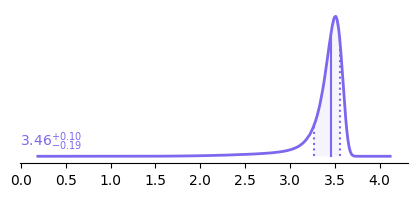

In [4]:
age_results_rv = make_pdf_from_samples(ages, n_bins=1000, kind='median')
age_results_rv.plot(label=True)

<Figure size 640x480 with 0 Axes>

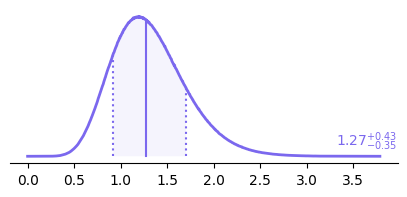

In [5]:
age_results_rv2 = make_pdf_from_samples(ages2, n_bins=1000, kind='median')
age_results_rv2.plot(label=True)

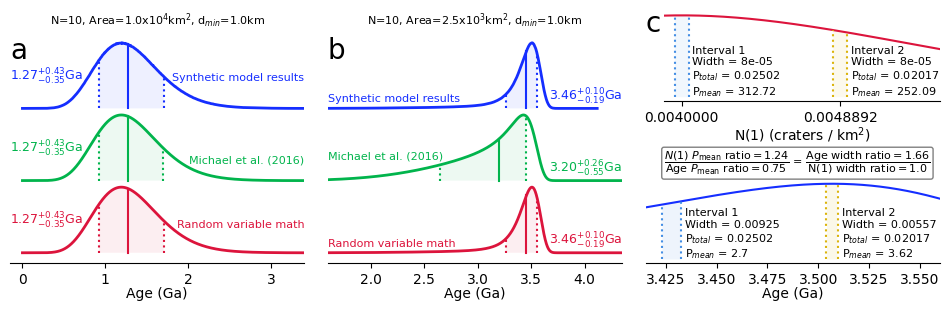

In [6]:
age_results_rv_dict = {
    area : age_results_rv,
    area2 : age_results_rv2
}

def age_method_fig(
    N, area, dmin, xlim=[0, 4.5], upshift=1.1,
    figsize=(5, 4), label_shift_x=0, label_shift_y=0,
    font_size=8, title_font_size=12, label_text_size=10,
    force_label_side='left', lys=[0, 0, 0]
):

    axis_exists = any(plt.gcf().get_axes())
    if not axis_exists:
        fig = plt.figure(figsize=(5, 2))
        ax = fig.add_subplot(111)
    else:
        ax = plt.gca()
    erase_box(ax)

    age_rv = age_pdf(N, area, dmin, kind='median')
    age_rv_m16 = m16_age_pdf(N, area, dmin)
    
    X = np.linspace(0, 4.5, 20000)
    
    age_rv = age_rv.match_X(X)
    age_rv_m16 = age_rv_m16.match_X(X)
    
    pdfs = [
        age_rv, age_rv_m16, age_results_rv_dict[area]
    ]
    colors = [
        'crimson', 'xkcd:shamrock', 'xkcd:vivid blue'
    ]
    labels = [
        'Random variable math', 
        'Michael et al. (2016)',
        'Synthetic model results',
    ]

    if force_label_side == 'left':
        ha = 'right'
        label_x = xlim[1]
    else:
        ha = 'left'
        label_x = xlim[0]
    
    for i in range(len(pdfs)):
        pdfs[i].plot(
            error_bar_type='median', label=True, 
            upshift=i * upshift, xlim=xlim, unit='Ga', color=colors[i], 
            force_label_side=force_label_side, 
            label_shift_x=label_shift_x, 
            label_shift_y=label_shift_y,
            label_text_size=label_text_size
        )
        plt.text(
            label_x, i * upshift + 0.3 + lys[i], labels[i], 
            size=font_size, color=colors[i], ha=ha
        )
    plt.xlabel('Age (Ga)', labelpad=0)
    plt.title(
        'N=' + str(N) + ', Area=' + scientific_notation(area) + \
            'km$^2$' + ', d$_{min}$=' + str(dmin) + 'km',
        fontsize=title_font_size
    )

def integrate_rv(rv, a, b, n_points=10000):
    X_full = rv.X
    P_full = rv.P / trapezoid(rv.P, X_full)
    X = np.linspace(a, b, n_points, endpoint=True)
    P = np.interp(X, X_full, P_full)
    return trapezoid(P, X)

N = model_N
age_rv = age_pdf(N, area, dmin)
N1_rv = N1_pdf(N, area, dmin)

fig = plt.figure(figsize=(12, 3))

ax = fig.add_subplot(131)
xlim = [-0.15, 3.4]
age_method_fig(
    10, area2, dmin, xlim=xlim, 
    label_shift_x=0, title_font_size=8,
    label_shift_y=0.2, label_text_size=9,
    force_label_side='left', lys=[0.09, -0.03, 0.12]
)
plt.text(xlim[0], 3.3, 'a', ha='left', va='top', size=20)

ax = fig.add_subplot(132)
xlim = [1.6, 4.35]
age_method_fig(
    10, area, dmin, xlim=xlim,
    label_shift_x=0, title_font_size=8,
    label_shift_y=0, label_text_size=9,
    force_label_side='right', lys=[-0.2, 0.03, -0.2]
)
plt.text(xlim[0], 3.3, 'b', ha='left', va='top', size=20)

ax = fig.add_subplot(133)

N = 10
area = 2500
dmin = 1
xlim = [3.415, 3.56]

bbox = {
    'facecolor' : 'white', 
    'edgecolor' : 'gray', 
    'boxstyle' : 'round,pad=0.2'
}

age_rv = age_pdf(N, area, dmin)
N1_rv = N1_pdf(N, area, dmin)
N1X, N1P = N1_rv.X, N1_rv.P
N1P = N1P / N1P.max()
N1_i1_low = (N - 0.1) / area
N1_i1_high = (N + 0.1) / area
N_i2 = ncf(age_rv.val) * area
N1_i2_low = (N_i2 - 0.1) / area
N1_i2_high = (N_i2 + 0.1) / area

def sy(N1):
    return np.interp(N1, N1X, N1P)
color_list = [
    'xkcd:dark sky blue', 'xkcd:dark sky blue', 
    'xkcd:gold', 'xkcd:gold'
]

ageX, ageP = age_rv.X, age_rv.P
ageP = ageP / ageP.max()
age_i1_low = ncf_inv(N1_i1_low)
age_i1_high = ncf_inv(N1_i1_high)
age_i2_low = ncf_inv(N1_i2_low)
age_i2_high = ncf_inv(N1_i2_high)
plt.plot(ageX, ageP, color='xkcd:vivid blue')
def age_y(age):
    return np.interp(age, ageX, ageP)
for edge, color in zip(
    [N1_i1_low, N1_i1_high, N1_i2_low, N1_i2_high], color_list
):
    plt.plot(
        [ncf_inv(edge), ncf_inv(edge)], [0, age_y(ncf_inv(edge))],
        ':', color=color
    )
shading_range = ((age_i1_low <= ageX) & (ageX <= age_i1_high))
ax.fill_between(
    ageX, 0, 0 + ageP, where=shading_range, 
    facecolor='xkcd:dark sky blue', alpha=0.09
)
shading_range = ((age_i2_low <= ageX) & (ageX <= age_i2_high))
ax.fill_between(
    ageX, 0, 0 + ageP, where=shading_range, 
    facecolor='xkcd:gold', alpha=0.09
)

P_i1 = integrate_rv(N1_rv, N1_i1_low, N1_i1_high)
age_P_i1 = integrate_rv(
    age_rv, ncf_inv(N1_i1_low), ncf_inv(N1_i1_high)
)

P_i2 = integrate_rv(N1_rv, N1_i2_low, N1_i2_high)
age_P_i2 = integrate_rv(
    age_rv, ncf_inv(N1_i2_low), ncf_inv(N1_i2_high)
)
w1_N1 = N1_i1_high - N1_i1_low
w2_N1 = N1_i2_high - N1_i2_low
w1_age = age_i1_high - age_i1_low
w2_age = age_i2_high - age_i2_low

plt.xlabel('Age (Ga)', labelpad=0)
erase_box(ax)
plt.xlim(xlim)
plt.ylim([-0.05, 3.0])
plt.text(xlim[0], 3.3, 'c', ha='left', va='top', size=20)

plt.text(
    age_i1_high + 0.002, 0.03,
    'Interval 1\nWidth = ' + str(round(w1_age, 5)) + \
    '\nP$_{total}$ = ' + str(round(age_P_i1, 5)) + \
    '\nP$_{mean}$ = ' + str(round(age_P_i1 / w1_age, 2)),
    fontsize=8
)
plt.text(
    age_i2_high + 0.002, 0.03,
    'Interval 2\nWidth = ' + str(round(w2_age, 5)) + \
    '\nP$_{total}$ = ' + str(round(age_P_i2, 5)) + \
    '\nP$_{mean}$ = ' + str(round(age_P_i2 / w2_age, 2)),
    fontsize=8
)

a = (age_P_i1 / w1_age) / (age_P_i2 / w2_age)
a = f"{a:.2f}"
b = (P_i1 / w1_N1) / (P_i2 / w2_N1)
b = f"{b:.2f}"
age_P_i1 = integrate_rv(
    age_rv, ncf_inv(N1_i1_low), ncf_inv(N1_i1_high)
)
age_P_i2 = integrate_rv(
    age_rv, ncf_inv(N1_i2_low), ncf_inv(N1_i2_high)
)
c = w1_age / w2_age
c = f"{c:.2f}"
d = f"{1.0}"
eq_str = (
    rf'$\dfrac{{N(1)\ P_{{\text{{mean}}}} \text{{ ratio}} = {b}}}' + \
    rf'{{\text{{Age }} P_{{\text{{mean}}}} \text{{ ratio}} = {a}}}$' + \
    rf' = ' + \
    rf'$\dfrac{{\text{{Age width ratio}} = {c}}}' + \
    rf'{{\text{{N(1) width ratio}} = {d}}}$'
)
plt.text(
    3.424, 1.23, eq_str,
    fontsize=8, bbox=bbox
)



ax_inset = fig.add_axes([0.67, 0.65, 0.23, 0.3])
plt.plot(N1X, N1P, color='crimson')
for edge, color in zip(
    [N1_i1_low, N1_i1_high, N1_i2_low, N1_i2_high], color_list
):
    plt.plot(
        [edge, edge], [0, sy(edge)],
        ':', color=color
    )
shading_range = ((N1_i1_low <= N1X) & (N1X <= N1_i1_high))
ax_inset.fill_between(
    N1X, 0, N1P, where=shading_range, 
    facecolor='xkcd:dark sky blue', alpha=0.07
)
shading_range = ((N1_i2_low <= N1X) & (N1X <= N1_i2_high))
ax_inset.fill_between(
    N1X, 0, N1P, where=shading_range, 
    facecolor='xkcd:gold', alpha=0.07
)
plt.xlabel('N(1) (craters / km$^2$)', labelpad=0)
erase_box(ax_inset)
plt.xlim([0.0039, 0.00545])

plt.text(
    N1_i1_high + 0.00002, 0.03,
    'Interval 1\nWidth = ' + str(round(w1_N1, 7)) + \
    '\nP$_{total}$ = ' + str(round(P_i1, 5)) + \
    '\nP$_{mean}$ = ' + str(round(P_i1 / w1_N1, 2)),
    fontsize=8
)
plt.text(
    N1_i2_high + 0.00002, 0.03,
    'Interval 2\nWidth = ' + str(round(w2_N1, 7)) + \
    '\nP$_{total}$ = ' + str(round(P_i2, 5)) + \
    '\nP$_{mean}$ = ' + str(round(P_i2 / w2_N1, 2)),
    fontsize=8
)

plt.xticks([N / area, N_i2 / area])

plt.subplots_adjust(wspace=0.08, hspace=0.28)

plt.gcf().savefig('figs/MichaelEtAl2016_synth.pdf', bbox_inches='tight')